In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import cv2
import numpy as np

import pandas as pd
from typing import List, Tuple, Dict


import multiprocessing  as mp
import requests
import jsonlines
from tqdm import tqdm
import time
import random
from PIL import Image


from os import listdir
from os.path import isfile, join

In [2]:
import sys
sys.path.append("/data/hdd1/brain/BraTS19/YandexCup/ru-clip")

In [3]:
from clip.evaluate.utils import (
    get_text_batch, get_image_batch, get_tokenizer,
    show_test_images, show_similarity,
    prepare_classes, call_model,
    show_topk_probs,
    load_weights_only,
    get_topk_accuracy,
    show_topk_accuracy
)

In [4]:
# в csv file для каждого касса должен быть массив
model, args = load_weights_only("ViT-B/32-small",seq_length = 15)

/home/viktor.kumpan/.miniconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
Some weights of the model checkpoint at sberbank-ai/rugpt3small_based_on_gpt2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
model = model.cuda().float().eval()

In [68]:
class Sent2textDataset(Dataset):
    
    def __init__(self,path_t_csv, path_i_json, 
                 path_i_folder, down_data = False,
                 n_classes = 20, args = None,
                 tokenizer = None, clastering_mode = False,
                 transform = None, mode = "Sber",
                ):
        """
        path_t_csv - путь до csv файла с текстами
        path_i_json - путь до json файла с картинками
        path_i_folder - путь для сохранения скаченных фотографий
        clastering_mode - тексты разбиты на кластеры
        """
        self.text_data = pd.read_csv(path_t_csv)
        self.img_links = self._load_json_links(path_i_json) # links to download images
        
        
        self.path_to_img = path_i_folder if path_i_folder else path_i_json
        
        if down_data:
            manager = mp.Manager()
            self._imgs_path = manager.Queue()
            self._load_imgs(list(self.img_links.items()),n_workers = 16)
        else:
            #check data
            self._check_data_in_folder()
            
        self.clastering_mode = clastering_mode
        self.transform = transform
        self.args = args
        self.mode = mode
        # class count get for traning
        self.n_classes = n_classes
        # for tokenizer text, depend on model
        self.tokenizer = get_tokenizer() if tokenizer == None else tokenizer
        
        
    def __len__(self,):
        return self.text_data.id_img.unique().shape[0]
    
    
    def _stack_texts(self,now_idx):
        """
        return text.shape(1, self.n)
        """
        # get text with differend class or with currently class
        if self.clastering_mode:
            pass
        else:
            indexs = [random.randint(0,len(self.text_data)-1) for i in range(self.n_classes-1)]
            #проверка на совпадение индексов
            for i in range(len(indexs)):
                if indexs[i] == now_idx:
                    indexs[i] = now_idx + 1
            
            texts = []
            for i in indexs:
                t = self.text_data.iloc[i][0].split("SEP")[1:]
                t = t[random.randint(0,len(t)-1)]
                texts.append(t)
                
            return texts 
    
    
    def __getitem__(self,idx):
        name_img = self.text_data.iloc[idx,1]
                
        img = cv2.imread(f"{self.path_to_img}/{name_img}.jpg", cv2.IMREAD_COLOR)
        text = self.text_data.iloc[idx][0].split("SEP")[1:] # get gt text
        
        #get one random text
        txt_idx = random.randint(0,len(text)-1)
        text = text[txt_idx]
        
        texts = self._stack_texts(idx) # create new class
        
        gt_idx = random.randint(0,self.n_classes - 1)
        texts.insert(gt_idx, text)
        
        
        if self.mode == "Sber":
            assert self.args != None, f"Define args"
            input_ids, attention_mask = get_text_batch(texts, self.tokenizer, self.args)
            if self.transform == None:
                image = [Image.fromarray(img)] # get_image_batch take shape count_i,img_dat
                img_input = get_image_batch(image, self.args.img_transform, self.args)
            else:
                img_input = self.transform(img)
                
        return (img_input, input_ids, attention_mask), gt_idx, texts
        
        
    
    def _check_data_in_folder(self,):
        """
        Delete rows with csv file which no in folder.
        """
        #оставить в csv файле только те sample изображения которых есть в папке
        print(self.path_to_img)
        onlyfiles = {int(f[:-4]): True for f in listdir(self.path_to_img) if isfile(join(self.path_to_img, f))}
        counter = 0
        start_count = len(self.text_data.id_img.unique())
        for id_img in self.text_data.id_img.unique().copy():
            if onlyfiles.get(id_img) == None:
                self.text_data = self.text_data.drop(self.text_data[self.text_data.id_img == id_img].index)
            else:
                counter+= 1
        print(f"From {start_count} sample folder hasn't {start_count - counter}")
                
    
    def _load_json_links(self,data_path: str, only_i_from_csv = True)->Dict[int, Tuple[str,str]]:
        """
        load data with json to variable
        """
        data = {}
        only_csv_links = []
        with jsonlines.open(data_path) as reader:
            reader = tqdm(reader)
            for obj in reader:
                if obj['image'] not in data:
                    data[obj['image']] = obj['url']
                
        if only_i_from_csv:
            #скачивать изображения принадлежащие csv
            only_csv_links = {idx: data[idx] for idx in self.text_data.id_img.unique()}
            return only_csv_links
        
        return data
    
    
    def _worker(self,task):
        paths_img = self._load_img(task)
        self._imgs_path.put(paths_img)
        
    
    def _load_img(self,links: Tuple[int,str])->int:
        try:
            response = requests.get(f"{links[1]}")
            with open(f"{self.path_to_img}/{links[0]}.jpg", "wb") as img:
                if response.content:
                    img.write(response.content)
                    return links[0]
                else:
                    print(f"Oyy response empty, miss {links[0]}")
        except requests.exceptions.ConnectionError as e:
            print(f"Oyy, miss {links[0]}")
            
    def _load_imgs(self, links:  List[Tuple[int,str]], n_workers = 1) -> bool:
        """
        download imgs from network
        """
        all_row = set(self.text_data.id_img.unique())
        return_row = set()
        all_len = len(all_row)
        with mp.Pool(n_workers) as p:
            p.map(self._worker, links)
            
            for _ in range(len(links)):
                return_row.add(self._imgs_path.get())
                
        all_row.difference_update(return_row)
        
        for row in all_row:
             self.text_data = self.text_data.drop(self.text_data[self.text_data.id_img == row].index)
        
        assert all_len - len(all_row) == len(self.text_data.id_img.unique())
        
        print(f"Download photo {all_len - len(all_row)} with {all_len} finish")
        return True

In [69]:
path_t_csv = "data/60k_data_preproc.csv" #pd.read_csv("data/60k_data_preproc.csv")[:1000]
path_i_json = "data/images.json"
path_i_folder = "data/images"

ds = Sent2textDataset(path_t_csv,
                      path_i_json,path_i_folder,
                      down_data = False,
                      n_classes = 5,args = args)

5462418it [00:11, 477123.49it/s]


data/images
From 50971 sample folder hasn't 50038


In [71]:
data = ds[2]

In [72]:
img = data[0][0]
text_vect = data[0][1]
att = data[0][2]
texts = data[-1]
texts

['нил гейман коралина в страна кошмар',
 'флаг вдв купить полк',
 'зачем она всё шелка лоя ноты для пианино',
 'такси няндома номера телефон',
 'лилия целковикова волгоград фото']

In [73]:
with torch.no_grad():
    logits_per_image, logits_per_text = model(
        img_input={"x": img},
        text_input={"x": text_vect, "attention_mask":att}
    )

In [80]:
similarity = logits_per_text.cpu().numpy() / 100

In [83]:
similarity.shape

(5, 1)

In [81]:
data[-2]

3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


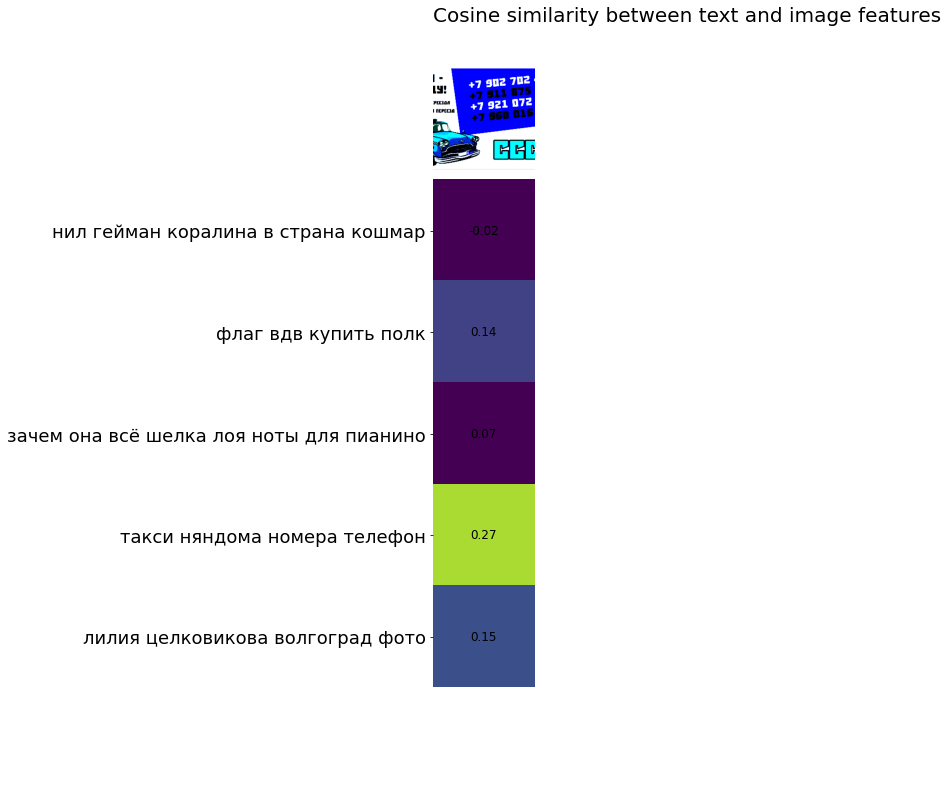

In [82]:
_ = show_similarity(img.cpu(), texts, similarity, args)

In [49]:
!rm -rf  data/images

In [50]:
!ls data/
!mkdir data/images

60k_data_preproc.csv  images.json  metadata.json


In [24]:
path_t_csv_no_clastr.id_img.copy()

1000     941193
1001     941193
1002     941193
1003    1370697
1004    1370697
         ...   
1995    4731110
1996    4731110
1997    4731110
1998    1444968
1999    1444968
Name: id_img, Length: 1000, dtype: int64